In [3]:
from imports import *

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
warnings.filterwarnings("ignore")

#### Load data, split and create dataset

In [6]:
timeseries = process_file()
len(timeseries)

154

In [7]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [127]:
lookback=7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

from utils import scale_data, LogMaxAbsScaler

X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_data(X_train, X_test, y_train, y_test)#, scaler_cls=LogMaxAbsScaler)

print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_test",X_test.shape, "y_test",y_test.shape)



X_train torch.Size([96, 7, 1]) y_train torch.Size([96, 7, 1])
X_test torch.Size([44, 7, 1]) y_test torch.Size([44, 7, 1])


#### Defining LSTM Model and hyperparameters

In [261]:
from model import LSTMModel

model = LSTMModel(input_size=lookback, num_layers=1, hidden_size=25)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=14, drop_last=True)

#### Training

In [262]:
from model import train_model
train_loss, train_rmse = train_model(model, loader, optimizer, loss_fn, n_epochs=1000, print_interval=50, seed=42)

Epoch 50/1000, Train Loss: 0.2673,  Train RMSE: 0.0564
Epoch 100/1000, Train Loss: 0.2201,  Train RMSE: 0.0512
Epoch 150/1000, Train Loss: 0.2030,  Train RMSE: 0.0492
Epoch 200/1000, Train Loss: 0.2072,  Train RMSE: 0.0497
Epoch 250/1000, Train Loss: 0.1981,  Train RMSE: 0.0486
Epoch 300/1000, Train Loss: 0.1919,  Train RMSE: 0.0478
Epoch 350/1000, Train Loss: 0.1914,  Train RMSE: 0.0477
Epoch 400/1000, Train Loss: 0.1822,  Train RMSE: 0.0466
Epoch 450/1000, Train Loss: 0.1671,  Train RMSE: 0.0446
Epoch 500/1000, Train Loss: 0.1668,  Train RMSE: 0.0446
Epoch 550/1000, Train Loss: 0.1634,  Train RMSE: 0.0441
Epoch 600/1000, Train Loss: 0.1590,  Train RMSE: 0.0435
Epoch 650/1000, Train Loss: 0.1545,  Train RMSE: 0.0429
Epoch 700/1000, Train Loss: 0.1482,  Train RMSE: 0.0420
Epoch 750/1000, Train Loss: 0.1454,  Train RMSE: 0.0416
Epoch 800/1000, Train Loss: 0.1392,  Train RMSE: 0.0407
Epoch 850/1000, Train Loss: 0.1341,  Train RMSE: 0.0400
Epoch 900/1000, Train Loss: 0.1335,  Train RMSE: 

In [263]:
X_train.shape

torch.Size([96, 7, 1])

#### Evaluating on train and test

In [264]:
train_preds = []
train_loss = []
test_loss = []
test_rmse = []
test_preds = []

model.eval()

# disable gradient computation
with torch.no_grad():
        epoch_test_loss = 0.0
        epoch_test_rmse = 0.0 
    
        
        y_pred_train = model(X_train[:len(train)])
        # me quedo con la ultima prediccion del lookback window (segunda componente del tensor)
        y_pred_train_unscaled = scaler_y.inverse_transform(y_pred_train[:, -1, :].detach().numpy().reshape(-1,1))
        train_preds.append(y_pred_train_unscaled)

        # mas de 1 feature
        # train_loss.append(loss_fn(y_pred_train[:, 0], y_train).item())
        # train_rmse.append(np.sqrt(loss_fn(y_pred_train[:, 0], y_train).item()))

        train_loss.append(loss_fn(y_pred_train, y_train).item())
        train_rmse.append(np.sqrt(loss_fn(y_pred_train, y_train).item()))
    
        y_pred_test = model(X_test[:len(test)])
        # me quedo con la ultima prediccion del lookback window (segunda componente del tensor)
        y_pred_test_unscaled = scaler_y.inverse_transform(y_pred_test[:, -1, :].detach().numpy().reshape(-1,1))
        test_preds.append(y_pred_test_unscaled)

        # mas de 1 feature
        # test_loss.append(loss_fn(y_pred_test[:, 0], y_test).item()) 
        # test_rmse.append(np.sqrt(loss_fn(y_pred_test[:, 0], y_test).item()))

        test_loss.append(loss_fn(y_pred_test, y_test).item())
        test_rmse.append(np.sqrt(loss_fn(y_pred_test, y_test).item()))
    

In [265]:
# creo un array concatenando las predicciones
train_array = np.concatenate([tensor.flatten() for tensor in train_preds])
test_array = np.concatenate([tensor.flatten() for tensor in test_preds])
len(train_array), len(test_array)

(96, 44)

In [275]:
test_loss, train_loss

([0.03725652024149895], [0.021467631682753563])

#### Plotting results

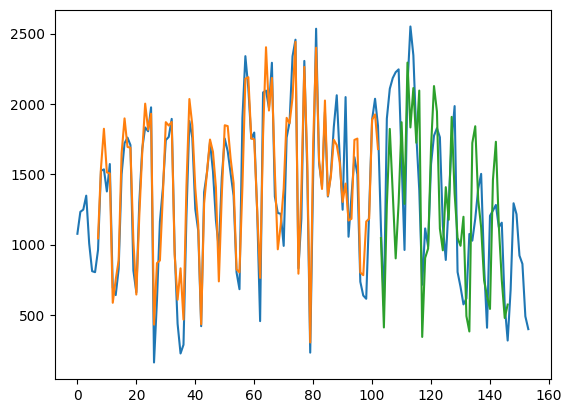

In [272]:
plt.plot(timeseries)
plt.plot(range(lookback, lookback + len(train_array)), train_array)
plt.plot(range(lookback + len(train_array), lookback + len(train_array) + len(test_array)), test_array)

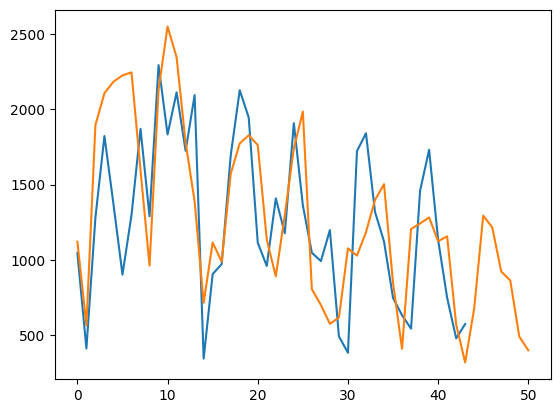

In [266]:
plt.plot(test_array)
plt.plot(test.squeeze())

In [267]:
len(test_array), len(test)

(44, 51)

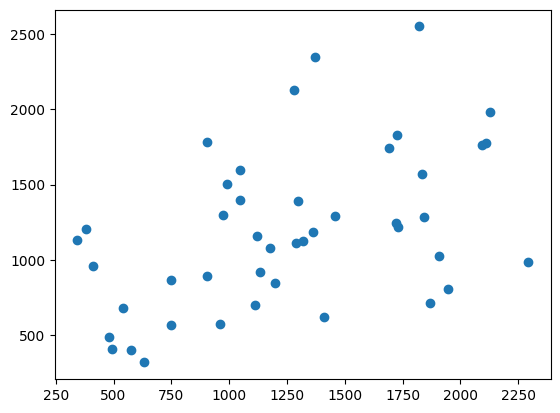

In [268]:
plt.scatter(test_array, test[lookback:])

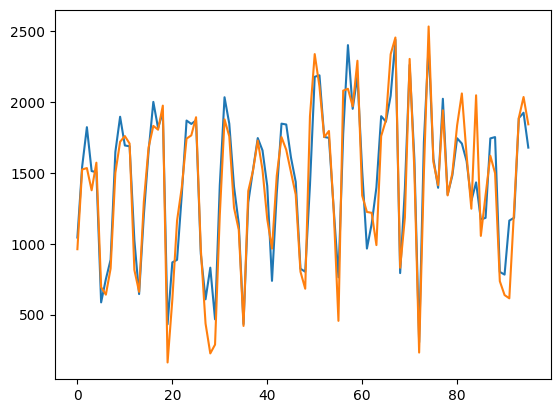

In [269]:
plt.plot(y_pred_train_unscaled.squeeze())
plt.plot(train.squeeze()[lookback:])

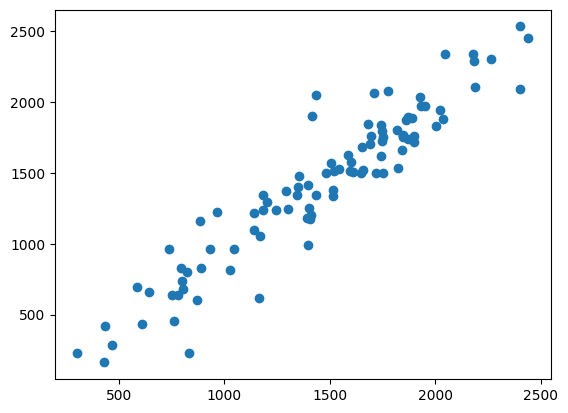

In [270]:
plt.scatter(train_array, train[lookback:])

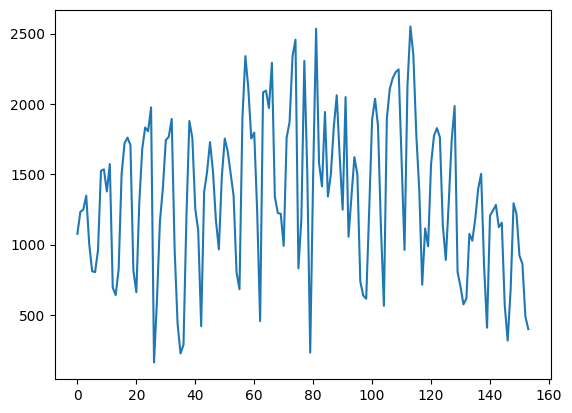

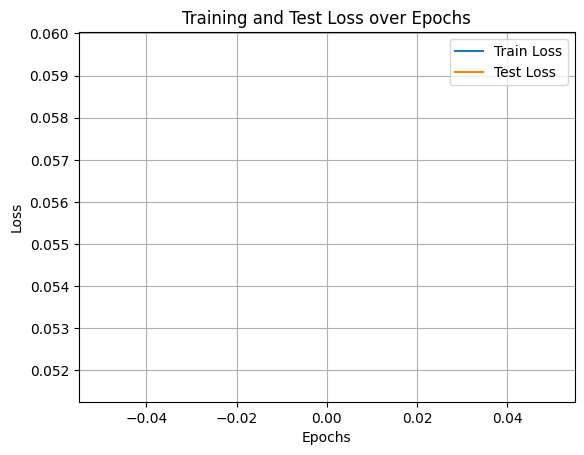

In [170]:
#epochs = range(0, n_epochs, 10)

#plt.plot(epochs, train_loss, label='Train Loss')
#plt.plot(epochs, test_loss, label='Test Loss')

plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')

plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()